In [3]:
import torch
from torch import nn
from torch.nn import functional as F

## Variational Auto Encoder
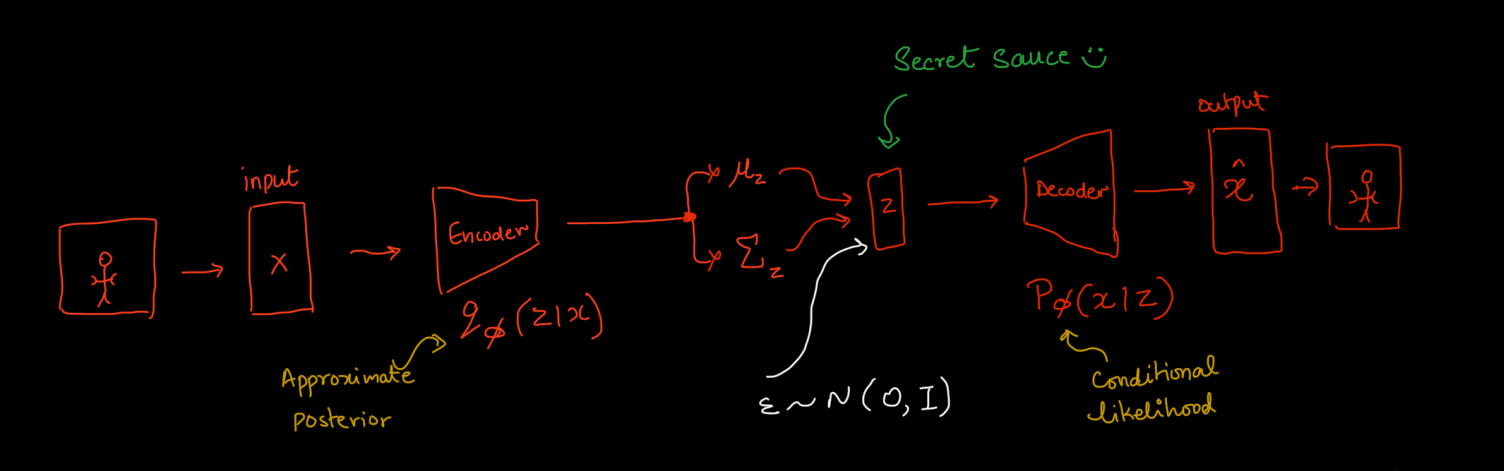

### Let's Code up the Encoder first !

Before we design the encoder architecture let us look at each component of the sequential layers that we will build.

Some pre-req:
- Convolutions
- Normalization (Batch Norm, Group Norm etc)
- Attention Mechanism (Go over the Transformer Architecture)

Some hand drawings, I made to step through the components of the layers. Focus on how the size of the batch of images change.

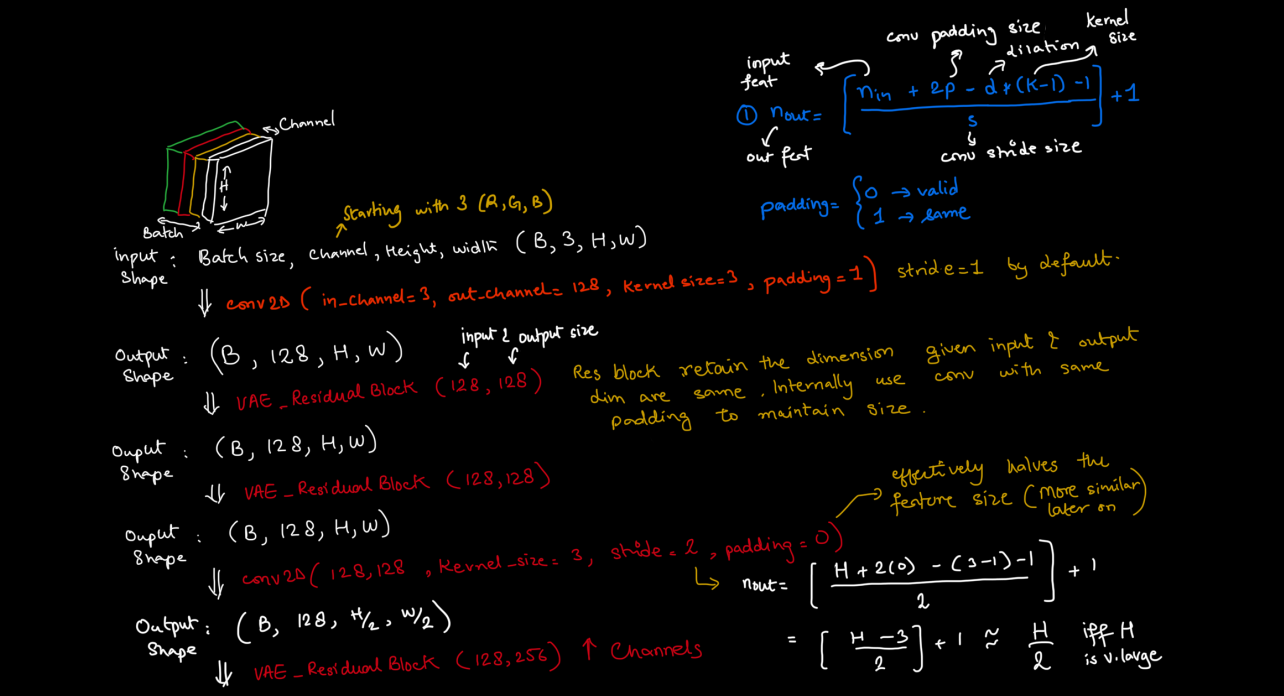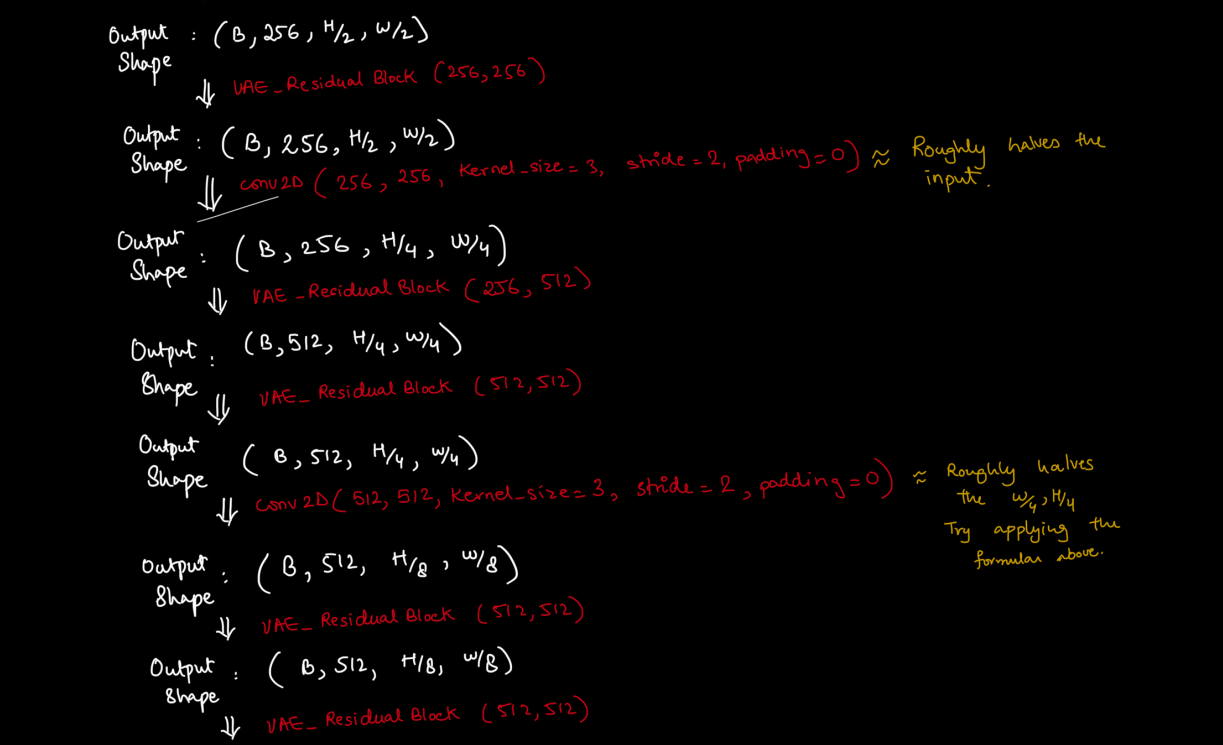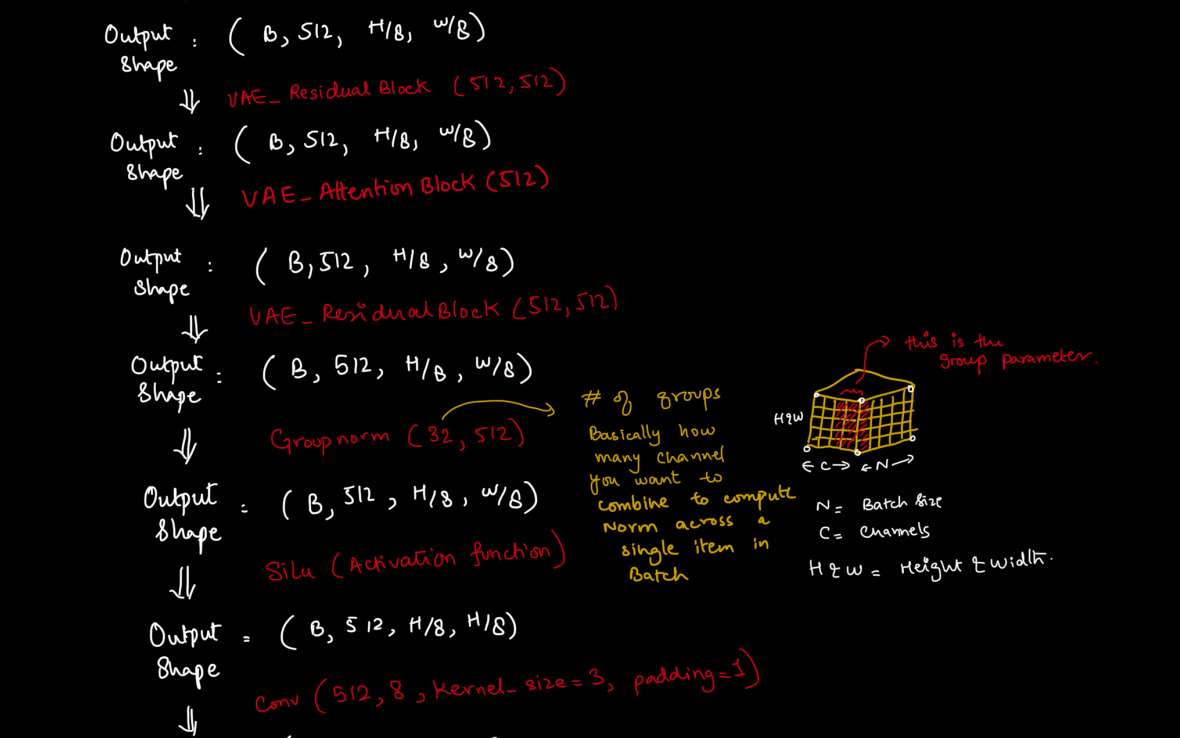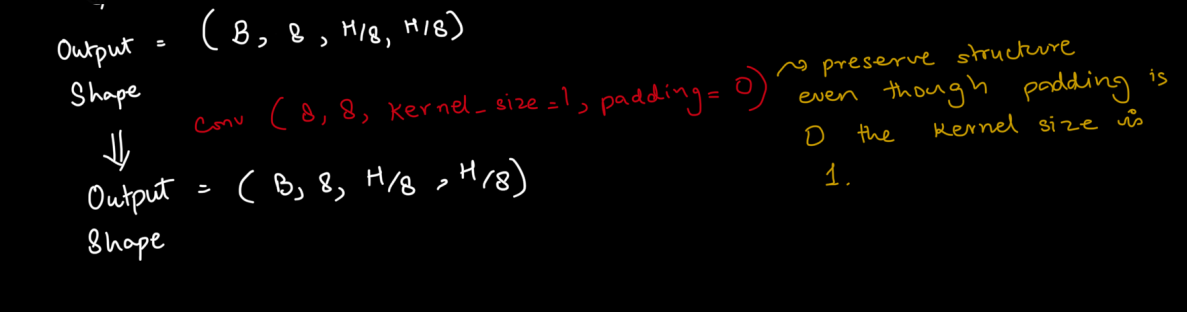

As you can observe that we have specified two blocks as the components of the sequential layer namely:

- VAE_ResidualBlock
- VAE_AttentionBlock

So, we need to design them first


In [6]:
class VAE_AttentionBlock(nn.Module):
  pass

In [5]:
class VAE_ResidualBlock(nn.Module):
  pass

In [ ]:
class VAE_Encoder(nn.Sequential):
  def __init__(self):
    super().__init__(
      nn.conv2d(3,128,kernel_size=3,padding=1),
      VAE_ResidualBlock(128,128),
      VAE_ResidualBlock(128,128),
      nn.conv2d(128,128,kernel_size=3,stride=2,padding=0),
      VAE_ResidualBlock(128,256),
      VAE_ResidualBlock(256,256),
      nn.conv2d(256,256,kernel_size=3,stride=2,padding=0),
      VAE_ResidualBlock(256,512),
      VAE_ResidualBlock(512,512),
      nn.conv2d(512,512,kernel_size=3,stride=2,padding=0),
      VAE_ResidualBlock(512,512),
      VAE_ResidualBlock(512,512),
      VAE_ResidualBlock(512,512),
      VAE_AttentionBlock(512),
      VAE_ResidualBlock(512,512),
      nn.GroupNorm(32,512),
      nn.SiLU(),
      nn.conv2d(512,8,kernel_size=3,padding=1),
      nn.conv2d(8,8,kernel_size=1,padding=0),
    )
  def forward(self,x,noise):
    '''
      Arg:
        x -> Input Image Tensor
             Shape: (Batch Size, Number of Channels, Height , Width)
        noise -> This gaussian noise is used to sample from our Latent Space !
                 Look at the Variational Auto Encoder diagram above,
                 see that 'epsilon', this is exactly that
                 Shape: (Batch Size, 4, Height/8, Width/8) [Same shape as the shape of output of Encoder]
    '''
    for module in self:
      if getattr(module, 'stride', None) == (2,2):
        # read [1] below
        x = F.pad(x, (0,1,0,1))
      x = module(x)
    # read [2] below
    mean, log_variance = torch.chunk(input=x, chunks=2, dim=1)
    # read [3] below
    log_variance = torch.clamp(log_variance, -30, 20)
    variance = log_variance.exp()
    stdev = variance.sqrt()
    # read [4] below
    x = mean + stdev * noise
    # read [5] below
    x *= 0.18215

    return x

[1] Ref: [What does F.pad do?](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html)
    
* Asymmetric padding to handle downsampling with kernel=3, stride=2.
* Adds 1 pixel to the right and bottom to make dimensions even.
* Input:  (B, C, H, W) → (B, C, H+1, W+1)
* Output: (B, C, H//2, W//2)
* (0,1,0,1) -> (left, right, top, bottom)

[2] torch.chunk divides the tensor into # of chunks along the dim
* (B,4,H/8,W/8), (B,4,H/8,W/8) = (B,8,H/8,W/8)  

[3] To prevent:
1. Exploding Gradients
2. Numerical Underflow
3. Clamp the log variance between -30 and 20, variance is btw ~1e-13 and ~5e8

[4] Reparameterization Trick: Transform The noise ~ N(0, 1) into latent sample ~ N(mean, stdev²)
- Allows gradient propagation through `mean` and `stdev` by decoupling randomness (external `noise` tensor).
- Mathematically: If ε ~ N(0,1), then μ + σ·ε ~ N(μ, σ²).
- All operations are element-wise; input/output shapes remain consistent.
Shape: (B,4,H//8,W//8) → (B,4,H//8,W//8)
- General Intuition for what happens to Noise:
    - Noise Dist* stdev -> Scales the Noise Dist
    - Noise + mean -> Shifts Noise Dist
    
[5] Scale by a constant:
    [Constant Taken from here](https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1)
